In [9]:
#@title Download the MVTec dataset sample from Supervisely
!curl https://assets.supervisely.com/supervisely-supervisely-assets-public/teams_storage/W/6/pt/ANAGVgKaC62tTrDQWK5JhNP2dd8ynqaTKSM1QdVoAasmTdaLvBwCuW7nCrq9o9lLS2padKnV9QogVGFlEPg7vxEBPIfuFC2Yq7ELNW7xn2t1egLrQPoGpNFJobhh.tar --output mvtec.tar

#@title Extract and list cable images
!tar -xf mvtec.tar
!ls test/img/cable_*


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  548M  100  548M    0     0  17.0M      0  0:00:32  0:00:32 --:--:-- 18.4M
tar: Removing leading `/' from member names
test/img/cable_bent_wire_000.png
test/img/cable_bent_wire_001.png
test/img/cable_bent_wire_002.png
test/img/cable_bent_wire_003.png
test/img/cable_bent_wire_004.png
test/img/cable_bent_wire_006.png
test/img/cable_bent_wire_007.png
test/img/cable_bent_wire_008.png
test/img/cable_bent_wire_009.png
test/img/cable_bent_wire_012.png
test/img/cable_cable_swap_000.png
test/img/cable_cable_swap_001.png
test/img/cable_cable_swap_002.png
test/img/cable_cable_swap_004.png
test/img/cable_cable_swap_005.png
test/img/cable_cable_swap_007.png
test/img/cable_cable_swap_008.png
test/img/cable_cable_swap_009.png
test/img/cable_cable_swap_010.png
test/img/cable_cable_swap_011.png
test/img/cable_combined_008.png
test/img/cable_co

In [10]:
# Remove the existing repo folder if it’s half-broken
!rm -rf ZS-CLIP-AC-naive

# Clone again cleanly
!git clone https://github.com/akridata-ai/ZS-CLIP-AC-naive.git

# Move into the repo
%cd ZS-CLIP-AC-naive

# Checkout the branch
!git checkout -b feature/template-code origin/feature/template-code



Cloning into 'ZS-CLIP-AC-naive'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 2), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), done.
Resolving deltas: 100% (2/2), done.
/content/ZS-CLIP-AC-naive/ZS-CLIP-AC-naive
Branch 'feature/template-code' set up to track remote branch 'feature/template-code' from 'origin'.
Switched to a new branch 'feature/template-code'


In [11]:
#@title Move cable images into repo's data folder
!cp /content/test/img/cable_* data/


In [12]:
#@title Install dependencies
!pip install -qr requirements.txt


  Preparing metadata (setup.py) ... done


In [13]:
#@title Save cable-specific spec.py
%%writefile spec.py
"""
Spec containing the configuration for the defect classification task
"""
from pydantic import BaseModel


class DefectClassificationSpec(BaseModel):
    model_name: str = "ViT-B/32"
    use_dino: bool = True
    fusion_mode: str = "concat"
    alpha: float = 0.7
    class_names: list[str] = [
        "good",
        "bent_wire",
        "cable_swap",
        "combined",
        "cut_inner_insulation",
        "cut_outer_insulation",
        "missing_cable",
        "missing_wire",
        "poke_insulation"
    ]
    prompts: list[list[str]] = [
        # good
        [
          "a photo of an intact electrical cable with no defects, no cuts, no missing wires, outer insulation smooth",
          "an undamaged cable: correct wiring order, insulation unbroken, no bends or punctures",
          "clean cable with proper connector mapping, no swapped wires, no damage",
          "normal cable in good condition, all wires present, insulation intact, no visible anomalies",
          "pristine cable: no cracks, no holes, no cuts, no miswiring",
          "factory-new cable with correct pin order and continuous insulation"
        ],

        #bent_wire
        ["A cable with a wire bent out of shape",
         "A cable showing bent or distorted wire"],

        # cable_swap
        [
          "a photo of a miswired cable: wires swapped at the connector, wrong pin order",
          "cable with swapped connections: two wires crossed to the wrong terminals",
          "connector with incorrect wiring sequence, wires interchanged (cable swap defect)",
          "cable showing cross-connected leads, wrong color order at the plug",
          "misconnection at the connector: wire positions exchanged, mapping incorrect",
          "wires routed to wrong pins (swapped wiring) at the cable head",
          "defect: swapped wires at connector, incorrect pinout"
        ],

        # combined
        [
          "a photo of a cable with multiple defects at once (e.g., cut insulation and missing wire)",
          "cable showing combined anomalies: miswiring plus damaged insulation",
          "multiple simultaneous defects on one cable: missing conductor and outer cut",
          "compound cable defect with both structural damage and wiring error",
          "cable exhibiting more than one defect category in the same sample",
          "mixed defects: punctured insulation together with swapped wiring",
          "combined cable defect: two or more distinct problems visible"
        ],

        #cut_inner_insulation
        ["A cable with its inner insulation cut or sliced",
         "Cable showing damage to the inner insulation layer"],

        #cut_outer_insulation
        ["A cable with outer insulation cut",
         "Cable showing slice or tear on the outer insulation"],

        #missing_cable
        ["A cable missing an entire wire bundle",
         "A cable with an absent main cable section"],

        #missing_wire
        ["A cable missing a single wire",
         "A cable with one or more wires removed"],

        # poke_insulation
        [
          "a cable with a small round hole punctured through the insulation",
          "cable showing a sharp object poke defect in its insulation layer",
          "wire insulation with a visible puncture or small localized hole",
          "defect: insulation pierced but wire remains intact, not cut or missing",
          "close-up of a cable with poke damage, tiny hole or indentation in the sheath",
          "cable surface pierced with a sharp mark, unlike long cuts",
          "small puncture defect in cable insulation, insulation broken at a point"
        ]

  ]


Overwriting spec.py


In [14]:
#@title Save updated clip_ac.py
%%writefile clip_ac.py
"""
Zero-shot defect classification using CLIP
"""

import clip
import torch
from PIL import Image
from pathlib import Path
from spec import DefectClassificationSpec
import torchvision.transforms as T
import torch.nn.functional as F

# Load DINOv2 globally (avoid reloading for every image)
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dino_model.eval()
dino_preprocess = T.Compose([
    T.Resize(224, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

def classify_defects(test_dir, spec, return_paths=False):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load(spec.model_name, device=device)

    test_dir = Path(test_dir)
    img_paths = sorted(test_dir.glob("cable_*.png"))   # cable dataset

    y_true, y_pred, file_paths = [], [], []

    # Precompute text features
    text_features = []
    with torch.no_grad():
        for prompts in spec.prompts:
            tokens = clip.tokenize(prompts).to(device)
            encodings = model.encode_text(tokens)
            encodings = encodings / encodings.norm(dim=-1, keepdim=True)
            mean_encoding = encodings.mean(dim=0)
            mean_encoding = mean_encoding / mean_encoding.norm()
            text_features.append(mean_encoding)
    text_features = torch.stack(text_features).to(device)

    # Iterate images
    with torch.no_grad():
        for img_path in img_paths:
            label = next((cls for cls in spec.class_names if cls in img_path.stem), None)
            if label is None:
                continue
            img = Image.open(img_path).convert("RGB")

            # CLIP embedding
            clip_input = preprocess(img).unsqueeze(0).to(device)
            clip_features = model.encode_image(clip_input)
            clip_features = clip_features / clip_features.norm(dim=-1, keepdim=True)

            # DINOv2 embedding
            dino_input = dino_preprocess(img).unsqueeze(0)
            dino_features = dino_model(dino_input).detach()
            dino_features = dino_features / dino_features.norm(dim=-1, keepdim=True)

            # Fusion
            if spec.use_dino and spec.fusion_mode == "weighted":
                sim_clip = (clip_features @ text_features.T)
                dino_confidence = torch.norm(dino_features).item()
                sim = spec.alpha * sim_clip + (1 - spec.alpha) * (dino_confidence * sim_clip)

            elif spec.use_dino and spec.fusion_mode == "concat":
                fused_features = torch.cat([clip_features, dino_features.to(device)], dim=-1)
                fused_features = F.normalize(fused_features, dim=-1)

                expanded_text_features = []
                for tf in text_features:
                    pad = torch.zeros(dino_features.shape[-1], device=device)
                    expanded_text_features.append(torch.cat([tf, pad], dim=-1))
                expanded_text_features = torch.stack(expanded_text_features)
                expanded_text_features = F.normalize(expanded_text_features, dim=-1)

                sim = fused_features @ expanded_text_features.T

            else:
                sim = (clip_features @ text_features.T)

            pred_idx = sim.argmax(dim=-1).item()
            pred_label = spec.class_names[pred_idx]

            y_true.append(label)
            y_pred.append(pred_label)
            file_paths.append(str(img_path))

    if return_paths:
        return y_true, y_pred, file_paths
    else:
        return y_true, y_pred


Overwriting clip_ac.py


In [15]:
!pip install -q git+https://github.com/openai/CLIP.git


  Preparing metadata (setup.py) ... done


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 303MB/s]
100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 32.6MiB/s]
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_clas

CLIP + DINOv2 Logistic Regression Report (3-fold CV):
                      precision    recall  f1-score   support

           bent_wire       0.80      0.80      0.80        10
          cable_swap       0.78      0.70      0.74        10
            combined       0.00      0.00      0.00         2
cut_inner_insulation       0.73      0.80      0.76        10
cut_outer_insulation       0.64      0.90      0.75        10
                good       0.00      0.00      0.00         3
       missing_cable       0.89      0.80      0.84        10
        missing_wire       0.90      0.90      0.90        10
     poke_insulation       0.73      0.80      0.76        10

            accuracy                           0.76        75
           macro avg       0.61      0.63      0.62        75
        weighted avg       0.73      0.76      0.74        75



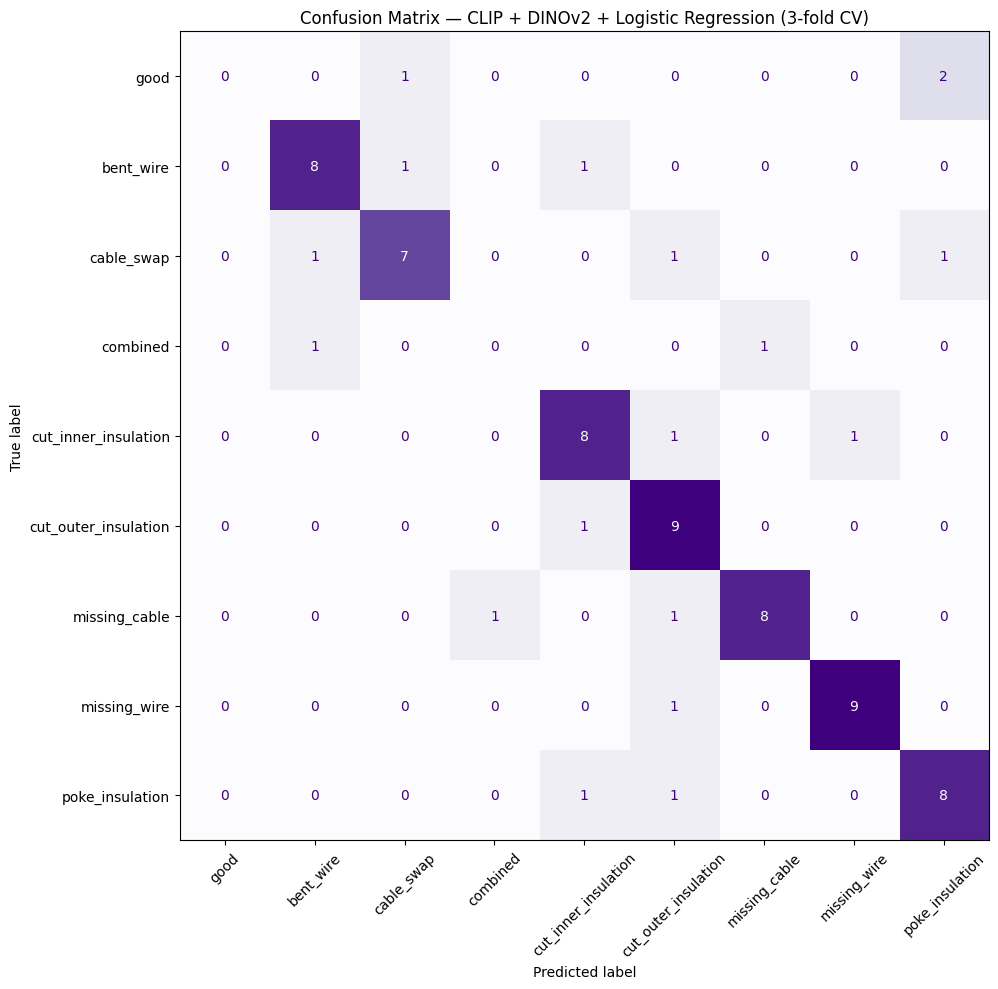

In [16]:
# -----------------------------
# CLIP + DINOv2 Fusion Features + Logistic Regression (with Cross-validation)
# -----------------------------

from spec import DefectClassificationSpec
from clip_ac import dino_model, dino_preprocess
import clip
import numpy as np
import torch
from pathlib import Path
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

def extract_clip_dino_embeddings(test_dir, spec):
    test_dir = Path(test_dir)
    img_paths = sorted(test_dir.glob("cable_*.png"))

    X, y, paths = [], [], []
    with torch.no_grad():
        for img_path in img_paths:
            # robust label parsing: match the full class name in the filename
            label = next((cls for cls in spec.class_names if cls in img_path.stem), None)
            if label is None:
                continue

            img = Image.open(img_path).convert("RGB")

            # CLIP embedding
            clip_input = clip_preprocess(img).unsqueeze(0).to(device)
            clip_features = clip_model.encode_image(clip_input)
            clip_features = clip_features / clip_features.norm(dim=-1, keepdim=True)
            clip_features = clip_features.cpu().numpy().flatten()

            # DINO embedding
            dino_input = dino_preprocess(img).unsqueeze(0)
            dino_features = dino_model(dino_input).detach()
            dino_features = dino_features / dino_features.norm(dim=-1, keepdim=True)
            dino_features = dino_features.cpu().numpy().flatten()

            # Fusion
            fused_features = np.concatenate([clip_features, dino_features])

            X.append(fused_features)
            y.append(label)
            paths.append(str(img_path))

    return np.array(X), np.array(y), paths


# ---- Train Logistic Regression on fused features ----
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import matplotlib.pyplot as plt

spec = DefectClassificationSpec()
X_fused, y_fused, paths_fused = extract_clip_dino_embeddings("data", spec)

# scaler + multinomial LR tends to work best here
clf_fused = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=None
    )
)

# use reproducible, stratified CV (min class size >= 3 → cv=3 is valid)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
y_pred_fused = cross_val_predict(clf_fused, X_fused, y_fused, cv=cv)

print("CLIP + DINOv2 Logistic Regression Report (3-fold CV):")
print(classification_report(y_fused, y_pred_fused, zero_division=0))

cm = confusion_matrix(y_fused, y_pred_fused, labels=spec.class_names)
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=spec.class_names)
disp.plot(cmap="Purples", ax=ax, xticks_rotation=45, colorbar=False)
ax.set_title("Confusion Matrix — CLIP + DINOv2 + Logistic Regression (3-fold CV)")
plt.tight_layout()
plt.show()
